In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib

In [2]:

def preprocess_image(image_path, target_size):
    img = Image.open(image_path)
    
    width, height = img.size
    
    if width > height:
        new_width = height
        left = (width - new_width) // 2
        right = left + new_width
        img = img.crop((left, 0, right, height))
    elif height > width:
        new_height = width
        top = (height - new_height) // 2
        bottom = top + new_height
        img = img.crop((0, top, width, bottom))
    
    img = img.resize(target_size)
    
    img_array = np.array(img)
    img_array = img_array / 255.0
    
    return img_array

image_dir = 'ISIC-images/'
target_size = (128, 128)

image_arrays = []

for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    img_array = preprocess_image(img_path, target_size=target_size)
    image_arrays.append(img_array)

X = np.array(image_arrays)

In [3]:
metadata = pd.read_csv('metadata.csv')
y = metadata['diagnosis']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
classInstances = y_train.value_counts()

In [6]:
classInstances

diagnosis
nevus                         6967
pigmented benign keratosis    1212
melanoma                      1158
basal cell carcinoma           563
squamous cell carcinoma        211
vascular lesion                161
dermatofibroma                 146
actinic keratosis              130
Name: count, dtype: int64

In [7]:
undersampler = RandomUnderSampler(sampling_strategy={'nevus': 2000}, random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

In [8]:
y_train_under.value_counts()

diagnosis
nevus                         2000
pigmented benign keratosis    1212
melanoma                      1158
basal cell carcinoma           563
squamous cell carcinoma        211
vascular lesion                161
dermatofibroma                 146
actinic keratosis              130
Name: count, dtype: int64

In [9]:
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train_under.reshape(X_train_under.shape[0], -1), y_train_under)

X_train_balanced = X_train_balanced.reshape(-1, 128, 128, 3)

In [10]:
y_train_balanced.value_counts()

diagnosis
actinic keratosis             2000
basal cell carcinoma          2000
dermatofibroma                2000
melanoma                      2000
nevus                         2000
pigmented benign keratosis    2000
squamous cell carcinoma       2000
vascular lesion               2000
Name: count, dtype: int64

In [11]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_balanced)
y_train_one_hot = to_categorical(y_train_encoded)
y_test_encoded = label_encoder.fit_transform(y_test)
y_test_one_hot = to_categorical(y_test_encoded)

In [24]:
model = Sequential()

model.add(Input(shape=(128, 128, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

Epoch 1/50


C:\Users\arsen\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 121s 230ms/step - accuracy: 0.1424 - loss: 2.0470 - val_accuracy: 0.2543 - val_loss: 1.6987
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 114s 227ms/step - accuracy: 0.2893 - loss: 1.7572 - val_accuracy: 0.4838 - val_loss: 1.5027
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 113s 224ms/step - accuracy: 0.3366 - loss: 1.6062 - val_accuracy: 0.4522 - val_loss: 1.4653
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 112s 223ms/step - accuracy: 0.3655 - loss: 1.5530 - val_accuracy: 0.4411 - val_loss: 1.2780
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 115s 229ms/step - accuracy: 0.4058 - loss: 1.4562 - val_accuracy: 0.5068 - val_loss: 1.2484
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 116s 230ms/step - accuracy: 0.4307 - loss: 1.4106 - val_accuracy: 0.4795 - val_loss: 1.2234
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 116s 230ms/step - accuracy: 0.4532 - loss: 1.3693 - val_accuracy: 0.5282 - val_loss: 1.1415
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 106s 211ms/step - accuracy: 0.4770 - loss: 1.31

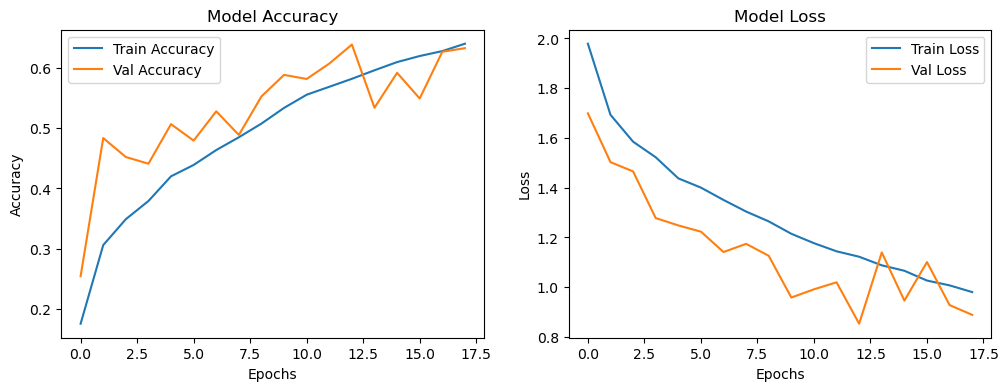

In [26]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

datagen.fit(X_train_balanced)


history = model.fit(
    datagen.flow(X_train_balanced, y_train_one_hot, batch_size=32),
    epochs=50,
    validation_data=(X_test, y_test_one_hot),
    callbacks=[early_stopping]
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step


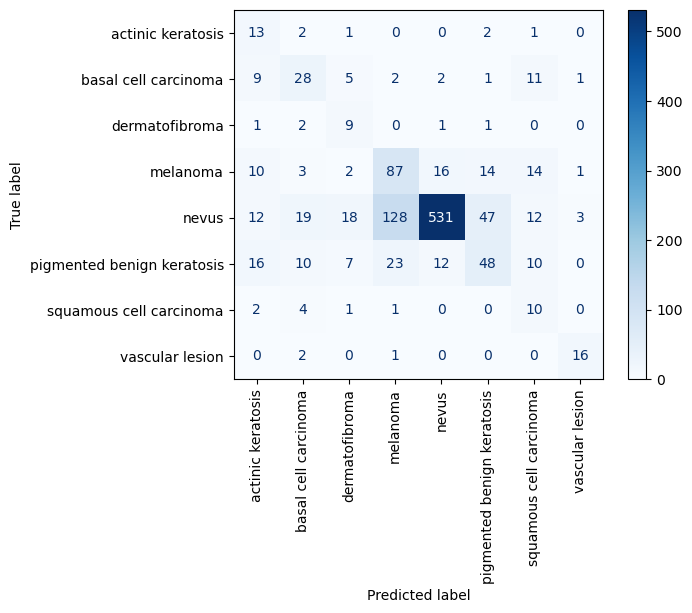

In [28]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation = 90)
plt.show()

In [12]:
X_under, y_under = undersampler.fit_resample(X.reshape(X.shape[0], -1), y)

In [13]:
X_balanced, y_balanced = oversampler.fit_resample(X_under.reshape(X_under.shape[0], -1), y_under)

X_balanced = X_balanced.reshape(-1, 128, 128, 3)

In [14]:
y_encoded = label_encoder.fit_transform(y_balanced)
y_one_hot = to_categorical(y_encoded)

In [15]:
model_final = Sequential()

model_final.add(Input(shape=(128, 128, 3)))
model_final.add(Conv2D(32, (3, 3), activation='relu'))
model_final.add(MaxPooling2D((2, 2)))
model_final.add(Conv2D(64, (3, 3), activation='relu'))
model_final.add(MaxPooling2D((2, 2)))
model_final.add(Conv2D(128, (3, 3), activation='relu'))
model_final.add(MaxPooling2D((2, 2)))
model_final.add(Conv2D(256, (3, 3), activation='relu'))
model_final.add(MaxPooling2D((2, 2)))

model_final.add(Flatten())
model_final.add(Dense(256, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(128, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(64, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(32, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


datagen_final = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

datagen_final.fit(X_balanced)
model_final.fit(datagen_final.flow(X_balanced, y_one_hot, batch_size=32), epochs=18)

Epoch 1/18


c:\Users\arsen\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 68s 130ms/step - accuracy: 0.2020 - loss: 1.9667
Epoch 2/18
500/500 ━━━━━━━━━━━━━━━━━━━━ 72s 143ms/step - accuracy: 0.3237 - loss: 1.6491
Epoch 3/18
500/500 ━━━━━━━━━━━━━━━━━━━━ 69s 138ms/step - accuracy: 0.3639 - loss: 1.5605
Epoch 4/18
500/500 ━━━━━━━━━━━━━━━━━━━━ 67s 132ms/step - accuracy: 0.3938 - loss: 1.5243
Epoch 5/18
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 130ms/step - accuracy: 0.4208 - loss: 1.4647
Epoch 6/18
500/500 ━━━━━━━━━━━━━━━━━━━━ 69s 137ms/step - accuracy: 0.4464 - loss: 1.4259
Epoch 7/18
500/500 ━━━━━━━━━━━━━━━━━━━━ 68s 136ms/step - accuracy: 0.4652 - loss: 1.3823
Epoch 8/18
500/500 ━━━━━━━━━━━━━━━━━━━━ 69s 136ms/step - accuracy: 0.4691 - loss: 1.3738
Epoch 9/18
500/500 ━━━━━━━━━━━━━━━━━━━━ 68s 134ms/step - accuracy: 0.4912 - loss: 1.3168
Epoch 10/18
500/500 ━━━━━━━━━━━━━━━━━━━━ 68s 135ms/step - accuracy: 0.5037 - loss: 1.3050
Epoch 11/18
500/500 ━━━━━━━━━━━━━━━━━━━━ 70s 140ms/step - accuracy: 0.5205 - loss: 1.2534
Epoch 12/18
500/500 ━━━━━━━━━━

In [16]:
joblib.dump(model_final, 'model.pkl')

['model.pkl']

In [27]:
classes = y_balanced.unique()
classes = pd.DataFrame(classes, columns=['class'])
classes.to_csv('classes.csv')